In [1]:
import matplotlib.pyplot as plt
import sympy as sp
import math
import json
from IPython.display import display, Markdown
import numpy as np

def cargar_datos(ruta):
    with open(ruta, 'r') as archivo:
        datos = json.load(archivo)
    return datos

def obtener_propiedades(datos, nombre_especie, propiedad):
    especie = datos.get(nombre_especie)
    if especie:
        return especie.get(propiedad)
    else:
        return None
   
def Cp_T(R,T,a_i,e_i):
    C_p = 0
    for index in enumerate(a_i):
        C_p += R*(a_i[index]*T**(e_i[index]))
    return C_p

def H_H0(R,T,a_i):
    T_0 = 298.15
    H = -a_i[0]/T + a_i[1]*math.log(T) + a_i[2]*T + a_i[3]*(T**2)/2 + a_i[4]*(T**3)/3 + a_i[5]*(T**4)/4 + a_i[6]*(T**5)/5
    H_0 = -a_i[0]/T_0 + a_i[1]*math.log(T_0) + a_i[2]*T_0 + a_i[3]*(T_0**2)/2 + a_i[4]*(T_0**3)/3 + a_i[5]*(T_0**4)/4 + a_i[6]*(T_0**5)/5
    return R * (H - H_0)/1000 # KJ/Kmol = J/mol

def S(R,T,a_i,b_i):
    S = -a_i[0]*(T**-2) - a_i[1]/T + a_i[2]*math.log(T) + a_i[3]*T + a_i[4]*(T**2)/2 + a_i[5]*(T**3)/3 + a_i[6]*(T**4)/4 + b_i[1]
    return R *(S) # J/mol K
 
def Kp_T(Eqn_1,coef_1,T,ruta_archivos):
    ## Constantes universales
    R = 8.31415 # KJ/ Kmol K = J/mol K

    # Fuentes y datos predeterminados
    j = len(Eqn_1)
    tipo = 'Especies'
    datos = cargar_datos(ruta_archivos.get(tipo))

    ## Obtención de datos de intervalo de temperatura (en este caso 200-1000)
    M_i = [0]*j
    a_i = [0]*j
    b_i = [0]*j
    e_i = [0]*j
    T_int = [0]*j

    for index,i in enumerate(Eqn_1):
        M_i[index] = obtener_propiedades(datos, i, 'MolecWeight')[0]
        a_i[index] = obtener_propiedades(datos, i, 'Intervals')[0]['a']
        b_i[index] = obtener_propiedades(datos, i, 'Intervals')[0]['b']
        e_i[index] = obtener_propiedades(datos, i, 'Intervals')[0]['exp']
        T_int[index] = obtener_propiedades(datos, i, 'Intervals')[0]['T_int']

    ## Obtención entalpía de formación
    hf_i = [0]*j

    for index,i in enumerate(Eqn_1):
        hf_i[index] = (obtener_propiedades(datos, i, 'Enthalpy')[0])

    ## Obtención de la entalpía sensible molar (variación respecto del estandar) de cada componente
    hs_T_i = [0]*j

    for index,a in enumerate(a_i):
        hs_T_i[index] = H_H0(R,T,a)

    ## Obtención de la entalpía molar (variación respecto del estandar) de cada componente (formación + sensible)
    h_T_i = [x + y for x, y in zip(hf_i, hs_T_i)]
    #h_T_i = hs_T_i * 1000

    ## Obtención de la entropía molar para una T de cada componente
    s_T_i = [0]*j
    for index,a in enumerate(a_i):
        b = b_i[index]
        s_T_i[index] = S(R,T,a,b)

    ## Entalpía y entropía molar de la reacción
    h_T_r = 0
    s_T_r = 0

    for index,nu in enumerate(coef_1):
        h_T_r += nu*h_T_i[index]
        s_T_r += nu*s_T_i[index]

    g_T_r = h_T_r - T*s_T_r

    ## Contante de equilibrio para la temperatura T
    K_T = math.exp(-g_T_r/(R*T))

    return [K_T,math.log10(K_T),(10**4)/T,1/K_T,math.log10(1/K_T),(10**4)/T,math.log(K_T)] 

def representar(coef_1,Eqn_1,T,T_intervalo,sol_unica,sol_int,sol_int_logkp,sol_int_10T,configuracion):
    reaccion = identif_reaccion(coef_1,Eqn_1,'Directa')
    if configuracion==0: #Kp y T
        T_vals = T_intervalo
        Kp_vals = sol_int
        T_punto = T  # para el caso de T
        Kp_punto = sol_unica[0] # extraigo solo la posición [0] que es K_p

        plt.figure(figsize=(10, 6))
        plt.scatter(T_punto, Kp_punto, color='red', label=f'$K_p(T= {T_punto} K$', zorder=3)
        plt.plot(T_vals, Kp_vals, label=f'$K_p(T)$')
        plt.title(f'Gráfico de $K_p(T)$ de la reacción {reaccion}')
        plt.xlabel('$T (K)$')
        plt.ylabel('$Kp(T)$')
        plt.legend()
        plt.grid(True)
        plt.show()
    elif configuracion==1: #log10Kp y 10^4/T
        T_vals = sol_int_10T
        Kp_vals = sol_int_logkp
        T_punto = 10**4 / T # para el caso de 10**4/T
        Kp_punto = sol_unica[1] # extraigo solo la posición [1] que es log10K_p

        plt.figure(figsize=(10, 6))
        plt.scatter(T_punto, Kp_punto, color='red', label=f'$log10K_p(10^4/T= {T_punto} K)$', zorder=3)
        plt.plot(T_vals, Kp_vals, label=f'$log10K_p(T)$')
        plt.title(f'Gráfico de $log10K_p(T)$ de la reacción {reaccion}')
        plt.xlabel('$10^4/T (K)$')
        plt.ylabel('$log10Kp(T)$')
        plt.legend()
        plt.grid(True)
        plt.show()

    else: #Mensaje de error
        print('Configuración no válida, elija entre 0 y 1')

def identif_reaccion(coef_1,Eqn_1,sentido):
    # Variable de reacción y reacción inversa
    reactivos = ''
    productos = ''
    n_reactivos = 0
    n_productos = 0
    
    # Bucle para contar positivos y negativos
    for j in coef_1:
        if j < 0:
            n_reactivos += 1
        elif j > 0:
            n_productos += 1

    # Bucle para separar entre productos y reactivos

    for index,i in enumerate(Eqn_1):
        if coef_1[index]<0:
            if n_reactivos > 1:
                reactivos += str(-coef_1[index])+ i + ' + '
                n_reactivos -= 1
            else:
                reactivos += str(-coef_1[index])+ i + '  '

        elif coef_1[index]>0:
            if n_productos > 1:
                productos += str(coef_1[index])+ i + ' + '
                n_productos -= 1
            else:
                productos += str(coef_1[index])+ i + '  '
        else:
            print('Error en la definición del string de la reacción')

    if sentido == 'Directa':
        return reactivos + '->  ' + productos
    elif sentido == 'Inversa':
        return productos + '->  ' + reactivos
    else:
        return reactivos + '->  ' + productos , productos + '->  ' + reactivos
    
##-----------EJECUCIÓN DE LA FUNCIÓN Kp(T)---------------------------------------------------------------------------
def ejecución_Kp_dir(Eqn_1,coef_1,T,T_intervalo,ruta_archivos):
    # Kp para T única
    sol_unica = Kp_T(Eqn_1,coef_1,T,ruta_archivos)

    # Kp para rango de T
    sol_int_Kp = [0]*len(T_intervalo)
    sol_int_log10kp = [0]*len(T_intervalo)
    sol_int_10T = [0]*len(T_intervalo)
    sol_int_logkp = [0]*len(T_intervalo)

    for index,T_n in enumerate(T_intervalo):
        sol_int = Kp_T(Eqn_1,coef_1,T_n,ruta_archivos)
        sol_int_Kp[index] = sol_int[0] # extraigo solo la posición [0] que es K_p
        sol_int_log10kp[index] = sol_int[1] 
        sol_int_10T[index] = sol_int[2]
        sol_int_logkp[index] = sol_int[6] 

    reaccion_directa = identif_reaccion(coef_1,Eqn_1,'Directa')

    return [reaccion_directa, sol_unica[1], sol_unica[2], sol_int_log10kp, sol_int_10T, sol_unica[0], sol_unica[6], sol_int_logkp, sol_int_Kp]


## solucion_unica = función Kp_T

# 0 - K_T
# 1 - math.log10(K_T)
# 2 - (10**4)/T
# 3 - 1/K_T
# 4 - math.log10(1/K_T)
# 5 - (10**4)/T
# 6 - math.log(K_T)

In [2]:
##-------------DATOS NECESARIOS PARA LA FUNCIÓN Kp-------------------------------------------------------------------------------------

## Ruta de archivos
ruta_archivos = {
    'Reactantes' : 'C:/Users/german.perez/OneDrive - Destinus NL BV/Escritorio/Personal/TFG/code/Bases de datos/Reactants.json',
    'Especies' : 'C:/Users/german.perez/OneDrive - Destinus NL BV/Escritorio/Personal/TFG/code/Bases de datos/Species.json',
    'Propulsantes' : 'C:/Users/german.perez/OneDrive - Destinus NL BV/Escritorio/Personal/TFG/code/Bases de datos/Propellants.json'
}

## Temperaturas
T = 1559 # K : Temperatura única en la que se analiza Kp
T_intervalo = list(range(300,3000,10)) # K  : intervalo de temperaturas en el que analizaremos Kp

## Nombre de las especies de la reacción
n_reacciones = 10 # Número de reacciones a evaluar

#       Eqn_1 = ['H','O2','OH','O'] #Productos y reactivos
#       coef_1 = [-1,-1,1,1] #Los negativos son para los reactivos y los positivos para los productos

Eqn_1 = ['O','H','OH'] #Productos y reactivos
coef_1 = [-1,-1,1] #Los negativos son para los reactivos y los positivos para los productos

Eqn_2 = ['O','O2']
coef_2 = [-2,1]

Eqn_3 = ['H','O2','OH','O']
coef_3 = [-1,-1,1,1]

Eqn_4 = ['H','OH','H2O']
coef_4 = [-1,-1,1]

Eqn_5 = ['H2','O','OH','H']
coef_5 = [-1,-1,1,1]

Eqn_6 = ['H2','OH','H2O','H']
coef_6 = [-1,-1,1,1]

Eqn_7 = ['H2O','O','OH']
coef_7 = [-1,-1,2]

Eqn_8 = ['K2CO3','K2O','CO2'] 
coef_8 = [-1,1,1] 

Eqn_9 = ['H2','O2','H2O']
coef_9 = [-1,-1/2,1]

Eqn_10 = ['CO','O2','CO2'] 
coef_10 = [-1,-1/2,1] 

## Listas de ejecución
Eqn_i = [0]*n_reacciones
coef_i = [0]*n_reacciones

for cont in range(n_reacciones):
    Eqn_i[cont] = eval(f'Eqn_{cont + 1}')
    coef_i[cont] = eval(f'coef_{cont + 1}')

In [3]:
#-------------EJECUCIÓN DE LAS FUNCIONES--------------------------------------------

nombres_r = [0]*len(Eqn_i)
sol_i_unica_kp = [0]*len(Eqn_i)
sol_i_unica_log10kp = [0]*len(Eqn_i)
sol_i_unica_10T = [0]*len(Eqn_i)
sol_i_unica_logkp = [0]*len(Eqn_i)
sol_i_int_kp = [0]*len(Eqn_i)
sol_i_int_log10kp = [0]*len(Eqn_i)
sol_i_int_10T = [0]*len(Eqn_i)
sol_i_int_logkp = [0]*len(Eqn_i)

for index,r in enumerate(Eqn_i):
    c = coef_i[index]
    sol_i = ejecución_Kp_dir(r,c,T,T_intervalo,ruta_archivos)
    nombres_r[index] = sol_i[0]
    sol_i_unica_log10kp[index] = sol_i[1]
    sol_i_unica_10T[index] = sol_i[2]

    sol_i_int_log10kp[index] = sol_i[3]
    sol_i_int_10T[index] = sol_i[4]
    
    sol_i_unica_kp[index] = sol_i[5]
    sol_i_unica_logkp[index] = sol_i[6]
    sol_i_int_logkp[index] = sol_i[7]
    sol_i_int_kp[index] = sol_i[8]

##  Kp_T
# 0 - K_T
# 1 - math.log10(K_T)
# 2 - (10**4)/T
# 3 - 1/K_T
# 4 - math.log10(1/K_T)
# 5 - (10**4)/T
# 6 - math.log(K_T)

## ejecución_Kp_dir
# 0 - reaccion_directa
# 1 - sol_unica[1]
# 2 - sol_unica[2]
# 3 - sol_int_log10kp
# 4 - sol_int_10T
# 5 - sol_unica[0]
# 6 - sol_unica[6]
# 7 - sol_int_logkp
# 8 - sol_int_kp


<>:14: SyntaxWarning: invalid escape sequence '\,'
<>:14: SyntaxWarning: invalid escape sequence '\,'
C:\Users\german.perez\AppData\Local\Temp\ipykernel_29092\4224219055.py:14: SyntaxWarning: invalid escape sequence '\,'
  plt.xlabel('$10^4/T \, (K^{-1})$')


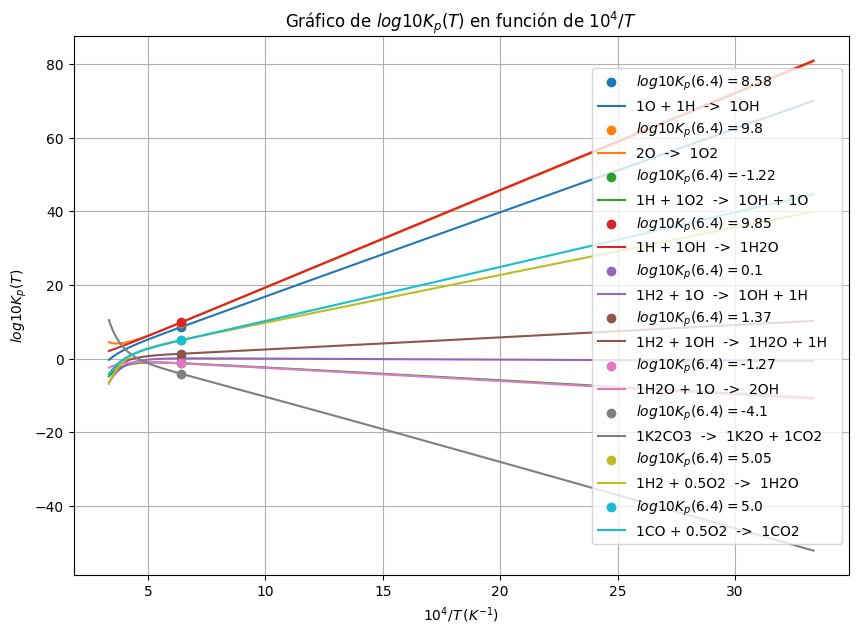

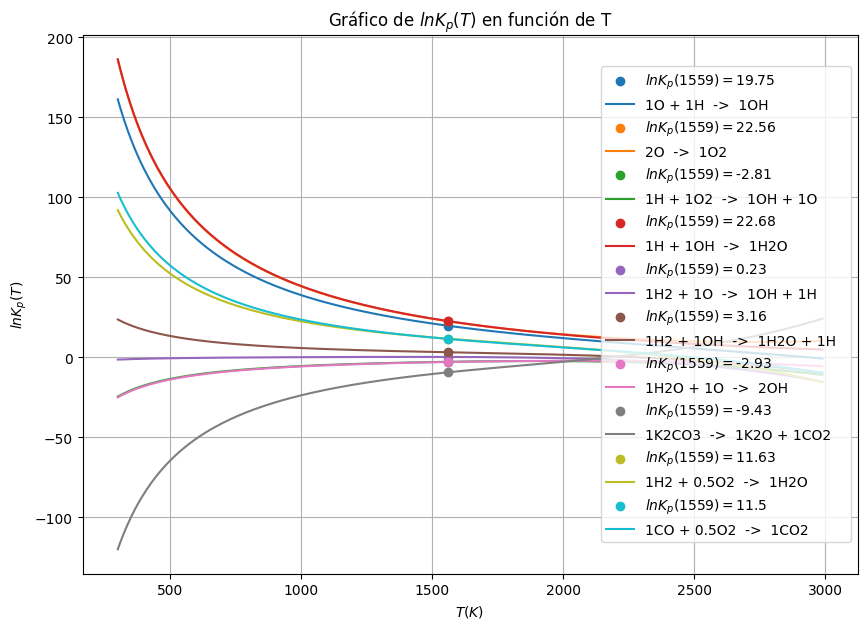

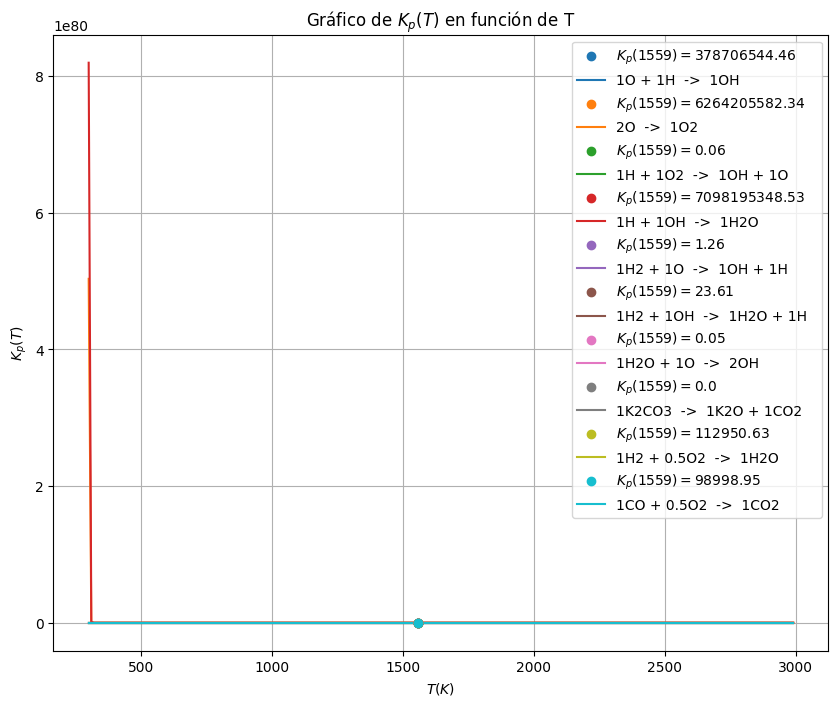

[378706544.46199435, 6264205582.335679, 0.06045563790720787, 7098195348.533093, 1.2594291090388336, 23.605807647942193, 0.053352510866054824, 8.03115070102059e-05, 112950.63403224472, 98998.95131746966]


In [12]:
#----------REPRESENTACIÓN GRÁFICA DE log10KP (única e intervalo)--------------------
plt.figure(figsize=(10, 7))

for index,r in enumerate(Eqn_i):
    
    T_vals = sol_i_int_10T[index]
    Kp_vals = sol_i_int_log10kp[index]
    T_punto = sol_i_unica_10T[index]
    Kp_punto =  sol_i_unica_log10kp[index] 

    plt.scatter(T_punto, Kp_punto, label=f'$log10K_p({round(T_punto,ndigits=1)}) = ${round(Kp_punto,ndigits=2)}', zorder=3)
    plt.plot(T_vals, Kp_vals, label=f'{nombres_r[index]}')
    plt.title('Gráfico de $log10K_p(T)$ en función de $10^4/T$')
    plt.xlabel('$10^4/T \, (K^{-1})$')
    plt.ylabel('$log10K_p(T)$')
    plt.legend(loc="right")
    plt.grid(True)

plt.show()


#----------REPRESENTACIÓN GRÁFICA DE lnKP (única e intervalo)--------------------

plt.figure(figsize=(10, 7))

for index,r in enumerate(Eqn_i):
    
    T_vals = T_intervalo
    Kp_vals = sol_i_int_logkp[index]
    T_punto = T
    Kp_punto = sol_i_unica_logkp[index] 

    plt.scatter(T_punto, Kp_punto, label=f'$lnK_p({round(T_punto,ndigits=1)}) = ${round(Kp_punto,ndigits=2)}', zorder=3)
    plt.plot(T_vals, Kp_vals, label=f'{nombres_r[index]}')
    plt.title('Gráfico de $lnK_p(T)$ en función de T')
    plt.xlabel('$T (K)$')
    plt.ylabel('$lnK_p(T)$')
    plt.legend(loc="right")
    plt.grid(True)

plt.show()

#----------REPRESENTACIÓN GRÁFICA DE KP (única e intervalo)--------------------

plt.figure(figsize=(10, 8))

for index,r in enumerate(Eqn_i):
    
    T_vals = T_intervalo
    Kp_vals = sol_i_int_kp[index]
    T_punto = T
    Kp_punto = sol_i_unica_kp[index] 

    plt.scatter(T_punto, Kp_punto, label=f'$K_p({round(T_punto,ndigits=1)}) = ${round(Kp_punto,ndigits=2)}', zorder=3)
    plt.plot(T_vals, Kp_vals, label=f'{nombres_r[index]}')
    plt.title('Gráfico de $K_p(T)$ en función de T')
    plt.xlabel('$T (K)$')
    plt.ylabel('$K_p(T)$')
    plt.legend()
    plt.grid(True)

plt.show()


print(sol_i_unica_kp)

In [7]:
for index,r in enumerate(Eqn_i):
    
    display(Markdown(f'La constante de equilibrio de la reacción {nombres_r[index]} será:'))
    display(Markdown(f'$K_p(T=$*{T}*$K ) = $ *{sol_i_unica_kp[index]}*'))
    display(Markdown(f'$log10K_p(T=$*{T}*$K ) = $ *{sol_i_unica_log10kp[index]}*'))
    #display(Markdown(f'$10^4/T con (T=$*{T}*$K ) = $ *{sol_i_unica_10T[index]}*'))

for index,r in enumerate(Eqn_i):
    
    display(Markdown(f'La constante de equilibrio de la reacción {nombres_r[index]} será:'))
    display(Markdown(f'$K_p(T=$*{T}*$K ) = $ *{sol_i_unica_kp[index]}*'))
    display(Markdown(f'$lnK_p(T=$*{T}*$K ) = $ *{sol_i_unica_logkp[index]}*'))
    #display(Markdown(f'$10^4/T con (T=$*{T}*$K ) = $ *{sol_i_unica_10T[index]}*'))

La constante de equilibrio de la reacción 1O + 1H  ->  1OH   será:

$K_p(T=$*1000*$K ) = $ *7.40669739568913e+16*

$log10K_p(T=$*1000*$K ) = $ *16.86962460169669*

La constante de equilibrio de la reacción 2O  ->  1O2   será:

$K_p(T=$*1000*$K ) = $ *1.761077548427015e+19*

$log10K_p(T=$*1000*$K ) = $ *19.245778480392264*

La constante de equilibrio de la reacción 1H + 1O2  ->  1OH + 1O   será:

$K_p(T=$*1000*$K ) = $ *0.004205775834405876*

$log10K_p(T=$*1000*$K ) = $ *-2.376153878695577*

La constante de equilibrio de la reacción 1H + 1OH  ->  1H2O   será:

$K_p(T=$*1000*$K ) = $ *2.2299746638716985e+19*

$log10K_p(T=$*1000*$K ) = $ *19.348299928786627*

La constante de equilibrio de la reacción 1H2 + 1O  ->  1OH + 1H   será:

$K_p(T=$*1000*$K ) = $ *1.0799664868158985*

$log10K_p(T=$*1000*$K ) = $ *0.03341027880477309*

La constante de equilibrio de la reacción 1H2 + 1OH  ->  1H2O + 1H   será:

$K_p(T=$*1000*$K ) = $ *325.1513832375118*

$log10K_p(T=$*1000*$K ) = $ *2.5120856058947116*

La constante de equilibrio de la reacción 1H2O + 1O  ->  2OH   será:

$K_p(T=$*1000*$K ) = $ *0.0033214267030413315*

$log10K_p(T=$*1000*$K ) = $ *-2.478675327089939*

La constante de equilibrio de la reacción 1K2CO3  ->  1K2O + 1CO2   será:

$K_p(T=$*1000*$K ) = $ *4.745291195468435e-11*

$log10K_p(T=$*1000*$K ) = $ *-10.32373713187636*

La constante de equilibrio de la reacción 1H2 + 0.5O2  ->  1H2O   será:

$K_p(T=$*1000*$K ) = $ *5738798384.720627*

$log10K_p(T=$*1000*$K ) = $ *9.758820967395266*

La constante de equilibrio de la reacción 1CO + 0.5O2  ->  1CO2   será:

$K_p(T=$*1000*$K ) = $ *16743726082.961555*

$log10K_p(T=$*1000*$K ) = $ *10.223852110598704*

La constante de equilibrio de la reacción 1O + 1H  ->  1OH   será:

$K_p(T=$*1000*$K ) = $ *7.40669739568913e+16*

$lnK_p(T=$*1000*$K ) = $ *38.843746132272415*

La constante de equilibrio de la reacción 2O  ->  1O2   será:

$K_p(T=$*1000*$K ) = $ *1.761077548427015e+19*

$lnK_p(T=$*1000*$K ) = $ *44.31504263201683*

La constante de equilibrio de la reacción 1H + 1O2  ->  1OH + 1O   será:

$K_p(T=$*1000*$K ) = $ *0.004205775834405876*

$lnK_p(T=$*1000*$K ) = $ *-5.471296499744418*

La constante de equilibrio de la reacción 1H + 1OH  ->  1H2O   será:

$K_p(T=$*1000*$K ) = $ *2.2299746638716985e+19*

$lnK_p(T=$*1000*$K ) = $ *44.55110699080184*

La constante de equilibrio de la reacción 1H2 + 1O  ->  1OH + 1H   será:

$K_p(T=$*1000*$K ) = $ *1.0799664868158985*

$lnK_p(T=$*1000*$K ) = $ *0.07693000992864545*

La constante de equilibrio de la reacción 1H2 + 1OH  ->  1H2O + 1H   será:

$K_p(T=$*1000*$K ) = $ *325.1513832375118*

$lnK_p(T=$*1000*$K ) = $ *5.784290868458078*

La constante de equilibrio de la reacción 1H2O + 1O  ->  2OH   será:

$K_p(T=$*1000*$K ) = $ *0.0033214267030413315*

$lnK_p(T=$*1000*$K ) = $ *-5.707360858529434*

La constante de equilibrio de la reacción 1K2CO3  ->  1K2O + 1CO2   será:

$K_p(T=$*1000*$K ) = $ *4.745291195468435e-11*

$lnK_p(T=$*1000*$K ) = $ *-23.77128322384761*

La constante de equilibrio de la reacción 1H2 + 0.5O2  ->  1H2O   será:

$K_p(T=$*1000*$K ) = $ *5738798384.720627*

$lnK_p(T=$*1000*$K ) = $ *22.47051568472207*

La constante de equilibrio de la reacción 1CO + 0.5O2  ->  1CO2   será:

$K_p(T=$*1000*$K ) = $ *16743726082.961555*

$lnK_p(T=$*1000*$K ) = $ *23.54128946284029*